# Volve Production Data Analysis
This body of work is a python based data analysis on the Volve data set. Read about the Volve dataset here:
https://www.equinor.com/en/how-and-why/digitalisation-in-our-dna/volve-field-data-village-download.html

In short, The Volve dataset is provided by Equinor. Its a complete data set on a sub-sea asset. Its more data than I have ever seen provided by any other E&P. Its glorious. 

The data analysis path I will follow is:

-Plot the production data and visually examine and explore

-Map the Data

-Do the wells talk to each other?


"""
                

unique days 3327
There are 6 producers
Production Wells: [7405, 7078, 5599, 5351, 7289, 5769]
There are 3 injectors
Injection Wells: [7405 5693 5769]


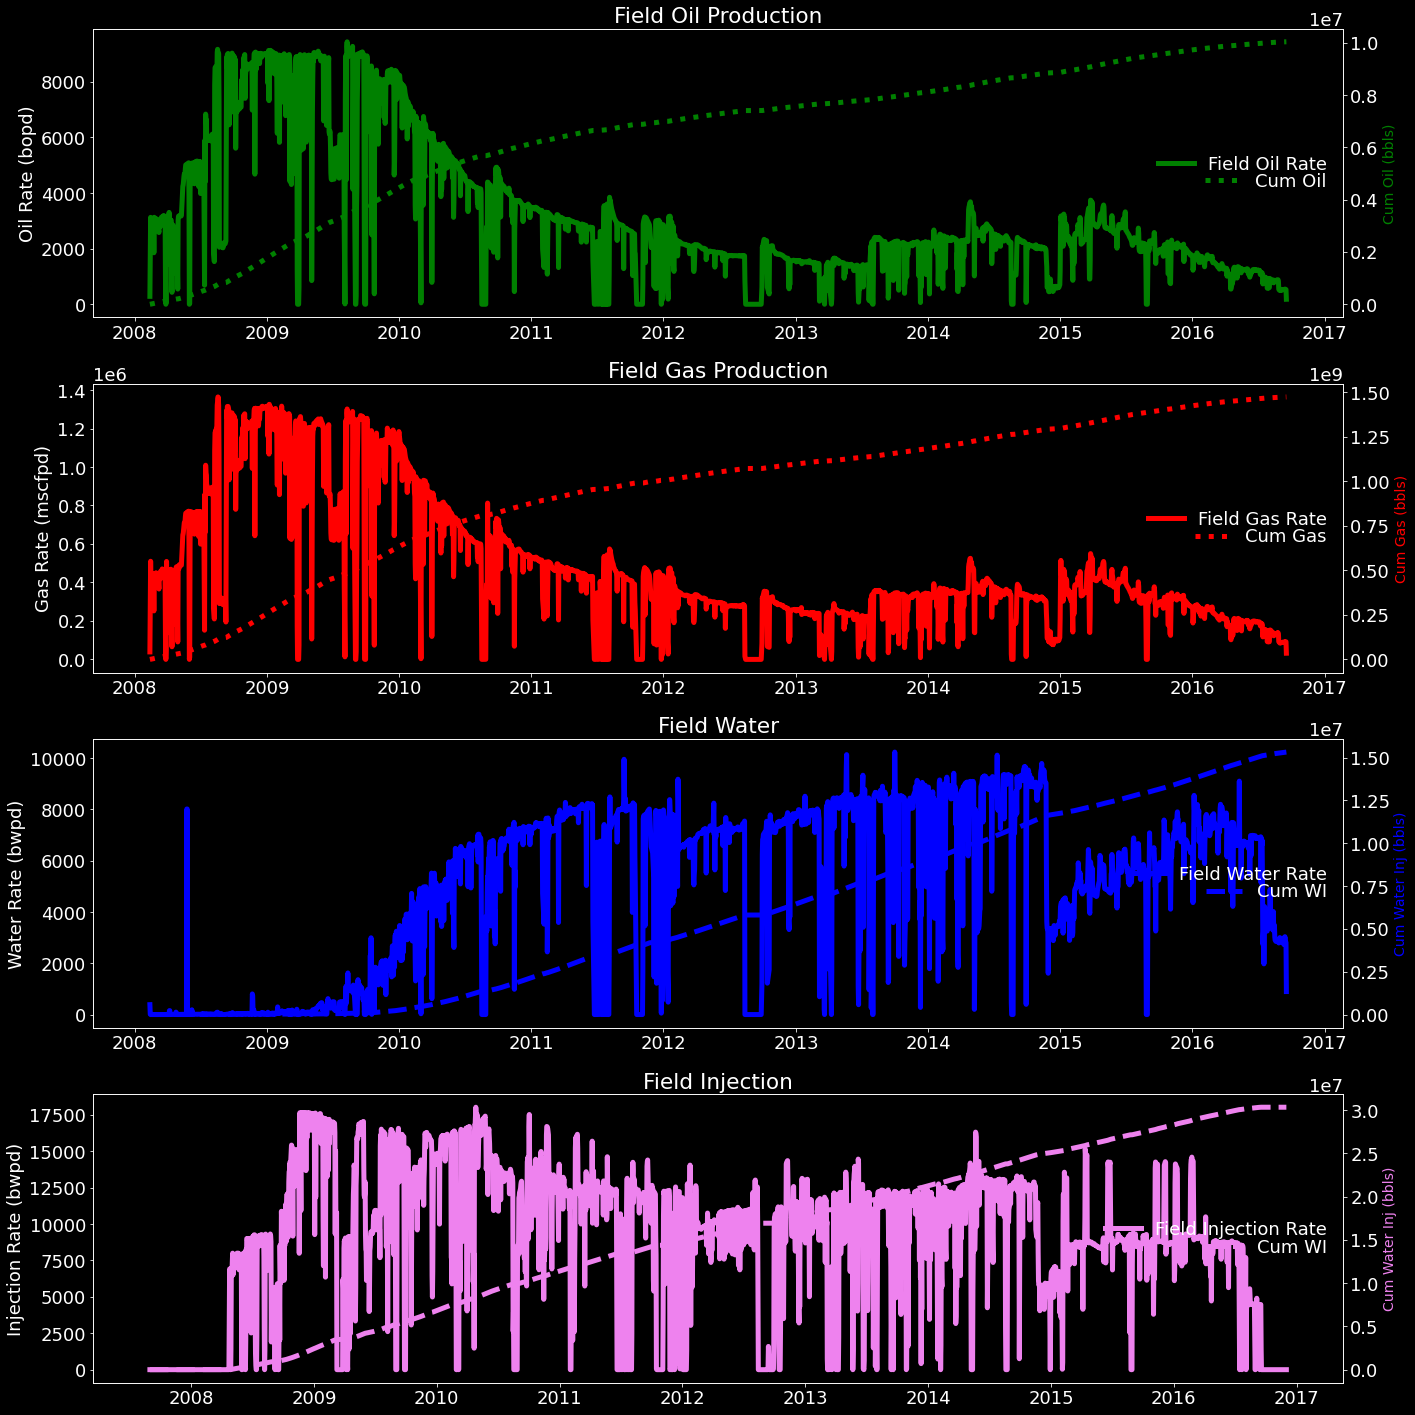

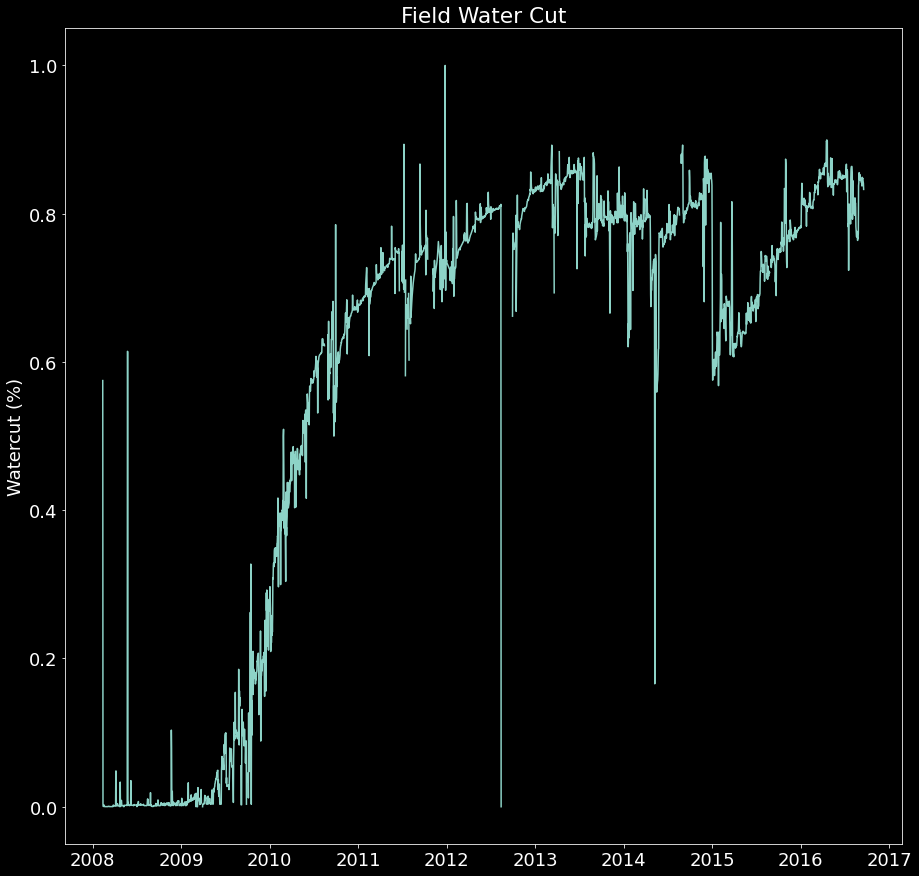

onto inj data stacked
onto inj by well


'Lets see where everything maps to get a sense of the spatial \narrangement of injectors and producers. To get the location data \nI had to scrape it from the drilling reports and added the data\nto the production data spreadsheet. The well collars are subsea\nso we cant make a classical topography map because, well, there\nis no topology. '

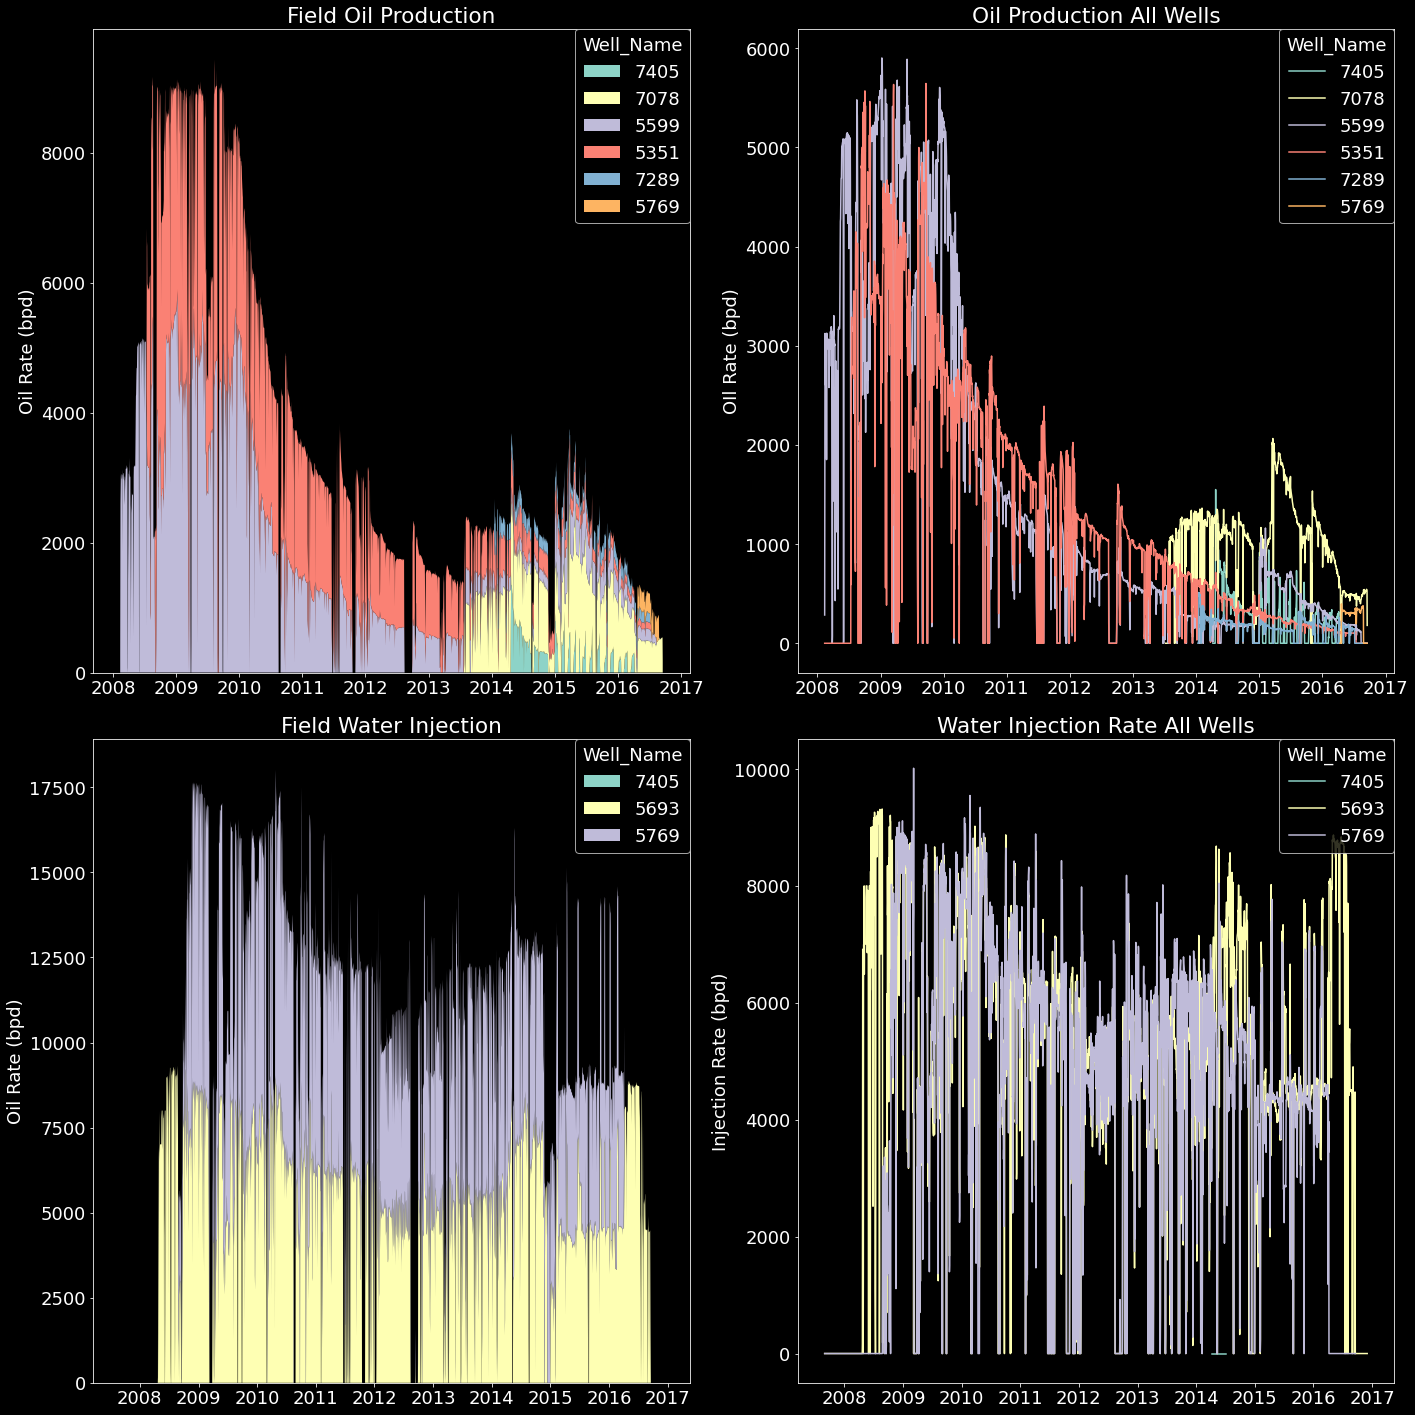

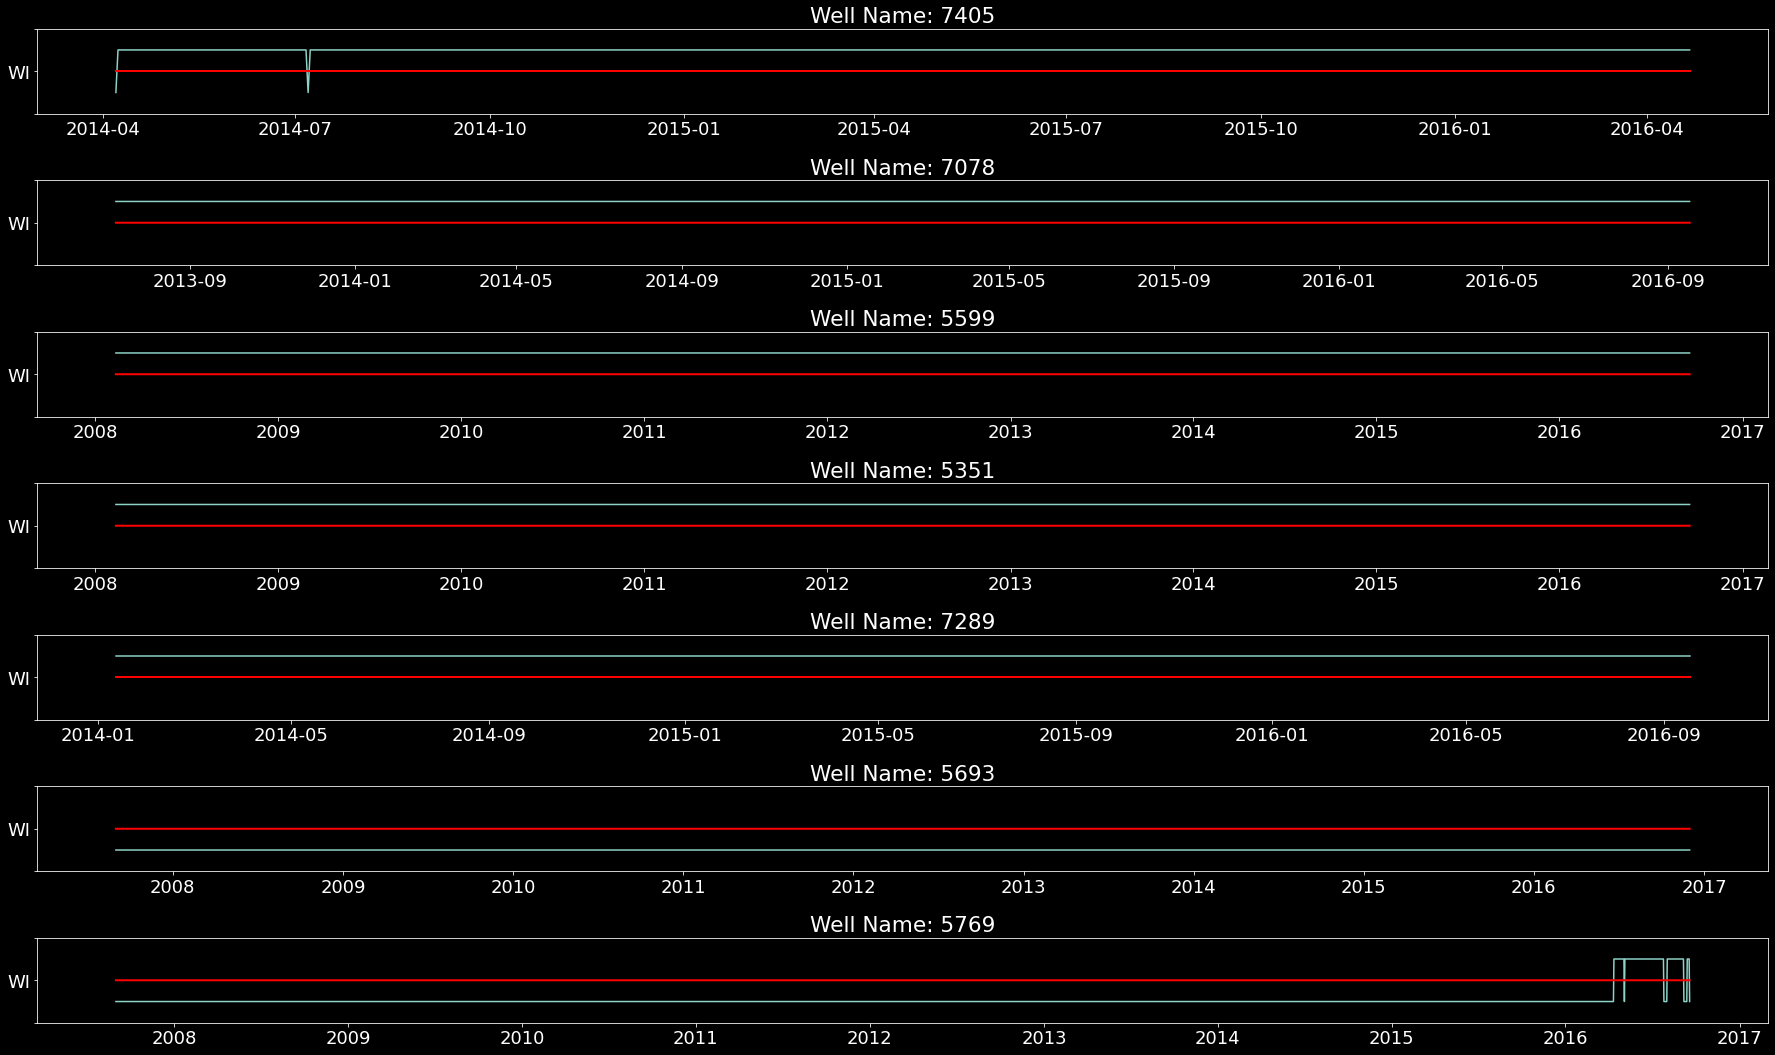

In [1]:
import pandas as pd
import datetime 
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
import numpy as np
from tabulate import tabulate


# I Like dark background charts - easier on the eyes
plt.style.use('dark_background')


#Set the name of the data file. Normally this would have traps and stuff to prevent
# a crash but since this is only for us, we will skip error trapping
xls = pd.ExcelFile('Volve_production_data.xlsx')
sheets = [xls.sheet_names]

#open the tabs and read the data
try:
    dd_df = pd.read_excel(xls, 'Daily Production Data')
    mm_df = pd.read_excel(xls, 'Monthly Production Data')
    loc_df = pd.read_excel(xls, 'Locations')
except:
    print('No file or tab in file')

# Set up the daily data frame for use as as time series 
dd_df['DateStamp'] = dd_df['DATEPRD']
print('unique days',len(dd_df['DATEPRD'].unique()))
dd_df['DateStamp'] = pd.to_datetime(dd_df['DateStamp'])
dd_df.index = dd_df['DateStamp']


# Here I get a list of the headers so I dont have to keep schecking on the names
#print(list(dd_df))
#
#['DATEPRD', 'WELL_BORE_CODE', 'NPD_WELL_BORE_CODE', 'NPD_WELL_BORE_NAME', 'NPD_FIELD_CODE', 
#'NPD_FIELD_NAME', 'NPD_FACILITY_CODE', 'NPD_FACILITY_NAME', 'ON_STREAM_HRS', 
#'AVG_DOWNHOLE_PRESSURE', 'AVG_DOWNHOLE_TEMPERATURE', 'AVG_DP_TUBING', 'AVG_ANNULUS_PRESS', 
#'AVG_CHOKE_SIZE_P', 'AVG_CHOKE_UOM', 'AVG_WHP_P', 'AVG_WHT_P', 'DP_CHOKE_SIZE', 'BORE_OIL_VOL', 
#'BORE_GAS_VOL', 'BORE_WAT_VOL', 'BORE_WI_VOL', 'FLOW_KIND', 'WELL_TYPE', 'DateStamp']"""

#Determine if there are producers and injectors, and make a list of each

#Test to see wht well types we have, producer, injector, waste, source
#print('Flow Kinds?', dd_df['FLOW_KIND'].unique())
# Injectors and Producers?
#Flow Kinds? ['production' 'injection']

#which well does what?

#Now we have to clean up the data
dd_df.fillna(0.0, inplace=True)
#are there any unexpected numbers. like negative production?
badnum = dd_df[dd_df['BORE_OIL_VOL'] < 0]
badnum = pd.concat([badnum, dd_df[dd_df['BORE_GAS_VOL'] < 0]])
badnum = pd.concat([badnum, dd_df[dd_df['BORE_WAT_VOL'] < 0]])
badnum = pd.concat([badnum, dd_df[dd_df['BORE_WI_VOL'] < 0]])
badnum = badnum[['NPD_WELL_BORE_CODE','BORE_OIL_VOL','BORE_GAS_VOL','BORE_WAT_VOL','BORE_WI_VOL']]
#badnum.rename(columns={"'NPD_WELL_BORE_CODE'": "Well_Bore"}, inplace=True)

badnum.rename(columns={'NPD_WELL_BORE_CODE': 'WellBore'}, inplace=True)
#print(tabulate(badnum, headers='keys', tablefmt='psql'))

#+---------------------+------------+----------------+----------------+----------------+---------------+
#| DateStamp           |   WellBore |   BORE_OIL_VOL |   BORE_GAS_VOL |   BORE_WAT_VOL |   BORE_WI_VOL |
#|---------------------+------------+----------------+----------------+----------------+---------------|
#| 2008-04-23 00:00:00 |       5599 |        2735.53 |      422115    |         -14.19 |             0 |
#| 2012-08-13 00:00:00 |       5599 |         632.96 |       12123.4  |        -457.84 |             0 |
#| 2009-03-03 00:00:00 |       5351 |        4339.13 |      616095    |          -0.95 |             0 |
#| 2012-08-13 00:00:00 |       5351 |         202.53 |        3754.12 |         -59.19 |             0 |
#+---------------------+------------+----------------+----------------+----------------+---------------+

""" There are 4 instances on 2 wells where a produced volume is strange. We dont know what the story is, 
on these wells. It could be they took some water on vacuum and the wells needed artifcal lift 
to get fluids to surface. Anyway, these values are trivial and will make for ugly charts if we
dont fix them now"""

dd_df['BORE_WAT_VOL'].clip(lower=0, inplace = True)

prd_df = dd_df[dd_df['WELL_TYPE'] == 'OP']
prd_wells = prd_df['NPD_WELL_BORE_CODE'].unique().tolist()
print('There are {} producers'.format(len(prd_wells)))
print('Production Wells: {}'.format(prd_wells))

inj_df = dd_df[dd_df['WELL_TYPE'] == 'WI']
inj_wells = inj_df['NPD_WELL_BORE_CODE'].unique()
print('There are {} injectors'.format(len(inj_wells)))
print('Injection Wells: {}'.format(inj_wells))


# We need to pivot the production data to a long df with wells as columns to make a stacked chart
prod_by_well = pd.pivot_table(prd_df,index=['DATEPRD'],values=["BORE_OIL_VOL"],columns=["NPD_WELL_BORE_CODE"])

#convert to a non-pivoted dataframe
prod_by_well = pd.DataFrame(prod_by_well.to_records())
#rename columns
prod_by_well.columns = [hdr.replace("('BORE_OIL_VOL', ", "").replace(")", "") \
                     for hdr in prod_by_well.columns]
#fill in nans with 0.0. We have to do this because when the data is pivoterd we add new 
# "data" without values
prod_by_well.fillna(0.0, inplace=True)
#prod_by_well['Total_Fluids']

#How much oil was produced over the life of the field?
prod_by_well['Field_OP_Rate'] = prod_by_well.sum(axis=1)
prod_by_well['Cum_OP_Volume'] = prod_by_well['Field_OP_Rate'].cumsum()

# We need to pivot the production data to a long df with wells as columns to make a stacked chart
gas_by_well = pd.pivot_table(prd_df,index=['DATEPRD'],values=["BORE_GAS_VOL"],columns=["NPD_WELL_BORE_CODE"])

#convert to a non-pivoted dataframe
gas_by_well = pd.DataFrame(gas_by_well.to_records())
#rename columns
gas_by_well.columns = [hdr.replace("('BORE_GAS_VOL', ", "").replace(")", "") \
                     for hdr in gas_by_well.columns]
#fill in nans with 0.0. We have to do this because when the data is pivoterd we add new 
# "data" without values
gas_by_well.fillna(0.0, inplace=True)

#How much gas was produced over the life of the field?"""
gas_by_well['Field_GP_Rate'] = gas_by_well.sum(axis=1)
gas_by_well['Cum_GP_Volume'] = gas_by_well['Field_GP_Rate'].cumsum()

# We need to pivot the production data to a long df with wells as columns to make a stacked chart
wat_by_well = pd.pivot_table(prd_df,index=['DATEPRD'],values=["BORE_WAT_VOL"],columns=["NPD_WELL_BORE_CODE"])

#convert to a non-pivoted dataframe
wat_by_well = pd.DataFrame(wat_by_well.to_records())
#rename columns
wat_by_well.columns = [hdr.replace("('BORE_WAT_VOL', ", "").replace(")", "") \
                     for hdr in wat_by_well.columns]
#fill in nans with 0.0. We have to do this because when the data is pivoterd we add new 
# "data" without values
wat_by_well.fillna(0.0, inplace=True)

#How much water was produced over the life of the field?"""
wat_by_well['Field_WP_Rate'] = wat_by_well.sum(axis=1)
wat_by_well['Cum_WP_Volume'] = wat_by_well['Field_WP_Rate'].cumsum()

# We need to pivot the injection data to a long df with wells as columns to make a stacked chart
inj_by_well = pd.pivot_table(inj_df,index=['DATEPRD'],values=["BORE_WI_VOL"],columns=["NPD_WELL_BORE_CODE"])

#convert to a non-pivoted dataframe
inj_by_well = pd.DataFrame(inj_by_well.to_records())
#rename columns
inj_by_well.columns = [hdr.replace("('BORE_WI_VOL', ", "").replace(")", "") \
                     for hdr in inj_by_well.columns]
#fill in nans with 0.0
inj_by_well.fillna(0.0, inplace=True)

#How much water was injected over the life of the field?"""
inj_by_well['Field_WI_Rate'] = inj_by_well.sum(axis=1)
inj_by_well['Cum_WI_Volume'] = inj_by_well['Field_WI_Rate'].cumsum()

"""Now lets make some visualizations"""
"""Field rates and Cum Volumes"""

fig, ax0 = plt.subplots(nrows=4, ncols=1, figsize=(20, 20))

'''Field Wide Oil Production '''
x = prod_by_well['DATEPRD'].tolist()
y1 = prod_by_well['Field_OP_Rate'].tolist()
y2 = prod_by_well['Cum_OP_Volume']
ax0[0].plot(x,y1,color='green', label = 'Field Oil Rate', linewidth = 5)
ax0[0].title.set_text('Field Oil Production')
ax0[0].set_ylabel('Oil Rate (bopd)')
ax0[0].legend(bbox_to_anchor=(1.0, 0.53),loc='center right', frameon=False)

ax00 =ax0[0].twinx()
# make a plot with different y-axis using second axis object
ax00.plot(x,y2,color="green", linestyle = 'dotted',label = "Cum Oil", linewidth = 5)
ax00.set_ylabel("Cum Oil (bbls)",color="green",fontsize=14)
ax00.legend(bbox_to_anchor=(1.0, 0.47),loc='center right', frameon=False)
fig.tight_layout()


''' Field Wide Gas Production '''
x = gas_by_well['DATEPRD'].tolist()
y1 = gas_by_well['Field_GP_Rate'].tolist()
y2 = gas_by_well['Cum_GP_Volume']
ax0[1].plot(x,y1,color='red', label = 'Field Gas Rate', linewidth = 5)
ax0[1].title.set_text('Field Gas Production')
ax0[1].set_ylabel('Gas Rate (mscfpd)')
ax0[1].legend(bbox_to_anchor=(1.0, 0.53),loc='center right', frameon=False)

ax11 =ax0[1].twinx()
# make a plot with different y-axis using second axis object
ax11.plot(x,y2,color="red", linestyle = 'dotted',label = "Cum Gas", linewidth = 5)
ax11.set_ylabel("Cum Gas (bbls)",color="red",fontsize=14)
ax11.legend(bbox_to_anchor=(1.0, 0.47),loc='center right', frameon=False)
fig.tight_layout()

''' Field Wide Water Production ''' 
x = wat_by_well['DATEPRD'].tolist()
y1 = wat_by_well['Field_WP_Rate'].tolist()
y2 = wat_by_well['Cum_WP_Volume']
ax0[2].plot(x,y1,color='blue', label = 'Field Water Rate', linewidth = 5)
ax0[2].title.set_text('Field Water')
ax0[2].set_ylabel('Water Rate (bwpd)')
ax0[2].legend(bbox_to_anchor=(1.0, 0.53),loc='center right', frameon=False)

ax22 =ax0[2].twinx()
# make a plot with different y-axis using second axis object
ax22.plot(x,y2,color="blue", linestyle = '--',label = "Cum WI", linewidth = 5)
ax22.set_ylabel("Cum Water Inj (bbls)",color="blue",fontsize=14)
ax22.legend(bbox_to_anchor=(1.0, 0.47),loc='center right', frameon=False)
fig.tight_layout()

''' Field Wide Water Injection ''' 
x = inj_by_well['DATEPRD'].tolist()
y1 = inj_by_well['Field_WI_Rate'].tolist()
y2 = inj_by_well['Cum_WI_Volume']
ax0[3].plot(x,y1,color='violet', label = 'Field Injection Rate', linewidth = 5)
ax0[3].title.set_text('Field Injection')
ax0[3].set_ylabel('Injection Rate (bwpd)')
ax0[3].legend(bbox_to_anchor=(1.0, 0.53),loc='center right', frameon=False)

ax33 =ax0[3].twinx()
# make a plot with different y-axis using second axis object
ax33.plot(x,y2,color="violet", linestyle = '--',label = "Cum WI", linewidth = 5)
ax33.set_ylabel("Cum Water Inj (bbls)",color="violet",fontsize=14)
ax33.legend(bbox_to_anchor=(1.0, 0.47),loc='center right', frameon=False)
fig.tight_layout()

plt.show()
# save the plot as a file
total_fluids = 1

""" Watercut """

field_water = wat_by_well[['DATEPRD','Field_WP_Rate']]
field_oil = prod_by_well[['DATEPRD','Field_OP_Rate']]
field_inj = inj_by_well[['DATEPRD','Field_WI_Rate']]

#field_df = pd.concat([field_water, field_oil,field_inj])
field_df = pd.merge(field_oil, field_water, on='DATEPRD', how='outer')
field_df = pd.merge(field_df, field_inj, on='DATEPRD', how='outer')
field_df['Field_Fluid_Prod'] = field_df['Field_OP_Rate'] + field_df['Field_WP_Rate']
field_df['Field_Watercut'] = field_df['Field_WP_Rate'] / field_df['Field_Fluid_Prod']
field_df['Field_Rep_Fact'] = field_df['Field_WI_Rate'] / field_df['Field_Fluid_Prod']

#dd_df['Total_Fluids_Prod'] = dd_df['BORE_OIL_VOL']
#'BORE_OIL_VOL', 'BORE_GAS_VOL', 'BORE_WAT_VOL', 'BORE_WI_VOL', 

""" Analysis of plots"""
x = field_df['DATEPRD']
y = field_df['Field_Watercut']

fig, axes = plt.subplots(figsize=(15, 15))
axes.plot(x,y)
axes.title.set_text('Field Water Cut')
axes.set_ylabel('Watercut (%)')
plt.show()
#make a list of lists for the stacked plot
prod = []
for i in prd_wells:
    temp = prod_by_well[str(i)].to_list()
    prod.append(temp)

fig, ax1 = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
#make a list of values for x
x = prod_by_well['DATEPRD'].tolist()
# Basic stacked area chart.
ax1[0,0].stackplot(x,prod, labels = prd_wells)
ax1[0,0].title.set_text('Field Oil Production')
ax1[0,0].set_ylabel('Oil Rate (bpd)')
fig.tight_layout()
ax1[0,0].legend(bbox_to_anchor=(1.0, 1), loc='upper right', borderaxespad=0., title = 'Well_Name')

for i in prd_wells:
    df = prd_df[prd_df['NPD_WELL_BORE_CODE'] == i]
    xh = df['DateStamp']
    yh = df['BORE_OIL_VOL']
    ax1[0,1].plot(xh, yh, label = str(i))
    
ax1[0,1].title.set_text('Oil Production All Wells')
ax1[0,1].set_ylabel('OIl Rate (bpd)')
fig.tight_layout()
ax1[0,1].legend(bbox_to_anchor=(1.0, 1), loc='upper right', borderaxespad=0., title = 'Well_Name')

print('onto inj data stacked')
inj = []
for i in inj_wells:
    temp = inj_by_well[str(i)].to_list()
    inj.append(temp)

x = inj_by_well['DATEPRD'].tolist()
# Basic stacked area chart.

ax1[1,0].stackplot(x,inj, labels = inj_wells)
ax1[1,0].title.set_text('Field Water Injection')
ax1[1,0].set_ylabel('Oil Rate (bpd)')
fig.tight_layout()
ax1[1,0].legend(bbox_to_anchor=(1.0, 1), loc='upper right', borderaxespad=0., title = 'Well_Name')
#ax1.plt.show()

print('onto inj by well')
for i in inj_wells:
    df = inj_df[inj_df['NPD_WELL_BORE_CODE'] == i]
    xh = df['DateStamp']
    yh = df['BORE_WI_VOL']
    ax1[1,1].plot(xh, yh, label = str(i))
    
ax1[1,1].title.set_text('Water Injection Rate All Wells')
ax1[1,1].set_ylabel('Injection Rate (bpd)')
fig.tight_layout()
ax1[1,1].legend(bbox_to_anchor=(1.0, 1), loc='upper right', borderaxespad=0., title = 'Well_Name')

#plt.show()

"""Now we can do a little bit of visual analysis.
Lets see what wells were injectors and producers 
over the life of the field"""

inj_prod_dict = {'OP' : 1 , 'WI' : -1}

dd_df['inj_prod'] = dd_df['WELL_TYPE'].map(inj_prod_dict)
well_list = dd_df['NPD_WELL_BORE_CODE'].unique().tolist()

well_num = len(dd_df['NPD_WELL_BORE_CODE'].unique())

fig, ax2 = plt.subplots(nrows=7, ncols=1, figsize=(25, 15))
j = 0
for i in well_list:
    df = dd_df[dd_df['NPD_WELL_BORE_CODE'] == i]
    x = df['DateStamp']
    y = df['inj_prod']
    zero = [0 for i in range(len(df))]
    ax2[j].plot(x, y)
    ax2[j].set_ylim(-2,2)
    ax2[j].title.set_text('Well Name: {}'.format(str(i)))
    ax2[j].plot(x, zero, color = 'red', lw=2)
    ax2[j].set_yticklabels(('','WI','','OP'))
    fig.tight_layout()
    #set_xticks(ticks, minor=False)
    j = j + 1
#plt.show()
    
""" The green line is the state of the well. It can be a producer 
(OP) if its above the red line, or an injector (WI) if its below
the red line. Well name 7405 spent two tiny stints as an injector. 
On reviewing the WI data no water was injected. Obviously an error
in the dataset. Wells 5693 and 5769 spent quite alot of time as 
injectors. Well 5769 was converted to a producer around Q2 2016"""

"""Lets see where everything maps to get a sense of the spatial 
arrangement of injectors and producers. To get the location data 
I had to scrape it from the drilling reports and added the data
to the production data spreadsheet. The well collars are subsea
so we cant make a classical topography map because, well, there
is no topology. """
